## 📸 특징들에 대해 더 알아보기: 물체 검출
이전 장에서는 이미지의 물체를 구분하기 위해서 gradient를 이용하여 edge를 검출하는 것으로 물체를 구분해왔다.  
이 장에서 이미지의 translation에 영향이 받지 않으며 더 나은 성능을 위해 다르게 접근해본다.
### 코너란?
코너는 에지의 교차점을 의미한다. 물론 교차점이 4개라고 해서 무조건 탁자라고 섣불리 판단은 할 수 없지만,  
(뭘 분류하느냐에 따라) 최선은 아니되 어느 정도 기준은 될 수가 있다..!

### 해리스 코너(Harris Corner)

In [5]:
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix, corner_peaks

<ipython-input-6-3e66437a1688>:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = rgb2gray(image)
<ipython-input-6-3e66437a1688>:4: FutureWarning: Until version 0.16, threshold_rel was set to 0.1 by default. Starting from version 0.16, the default value is set to None. Until version 0.18, a None value corresponds to a threshold value of 0.1. The default behavior will match skimage.feature.peak_local_max. To avoid this warning, set threshold_rel=0.
  coords = corner_peaks(corners, min_distance=5) #실제 코너를 찾는 함수


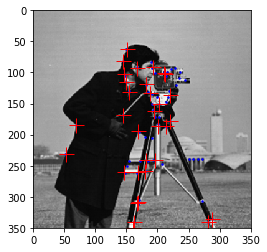

In [6]:
image = imread("test.png")
image = rgb2gray(image)
corners = corner_harris(image) #코너 픽셀일 가능성 측정
coords = corner_peaks(corners, min_distance=5) #실제 코너를 찾는 함수
coords_subpix = corner_subpix(image, coords, window_size=13) # 미세 조정하는데 도움이 되는 함수
fig, ax = plt.subplots()
ax.imshow(image,interpolation="nearest",cmap=plt.cm.gray)
ax.plot(coords[:,1], coords[:,0], ".b", markersize=3)
ax.plot(coords_subpix[:,1], coords_subpix[:,0], "+r",markersize=15)
ax.axis((0,350,350,0))
plt.show()

### 지역 이진 패턴(Local Binary Pattern)
직렬형 분류기, 이미지의 레이블 출력 시 블랙박스와 유사한 특징을 지니고 있다.   
기본적으로 지역 이진 패턴은 이웃하는 8개의 픽셀에서 픽셀 값이 중심 픽셀 값보다 클 경우 1, 아니면 0으로 할당한다.  
(정수형의 사용으로 학습과 테스트가 빠른 편이다. 보통 임베디드 응용프로그램에서 선호)


In [10]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage import io
from skimage.color import label2rgb
import numpy as np

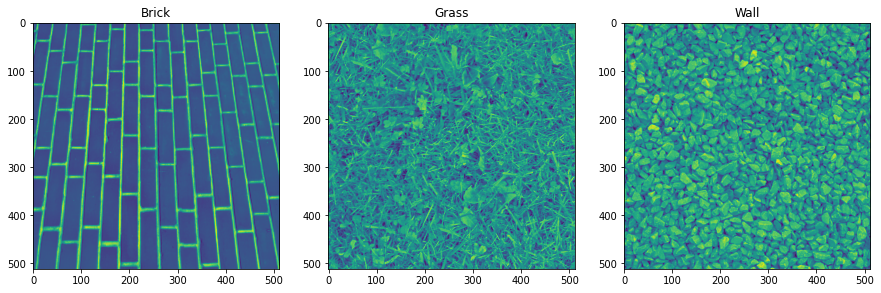

In [35]:
brick = data.brick()
grass = data.grass()
wall = data.gravel()

f = plt.figure(figsize=(15,15))
im1 = f.add_subplot(1, 3, 1)
im1.imshow(brick)
im1.set_title("Brick")

im2 = f.add_subplot(1, 3, 2)
im2.imshow(grass)
im2.set_title("Grass")

im3 = f.add_subplot(1, 3, 3)
im3.imshow(wall)
im3.set_title("Wall")
plt.show()

In [18]:
brick_lbp = local_binary_pattern(brick, 16,2,"uniform")
grass_lbp = local_binary_pattern(grass, 16,2,"uniform")
wall_lbp = local_binary_pattern(wall, 16,2,"uniform")

In [19]:
brick_rot = rotate(brick, angle=22, resize=False)
grass_rot = rotate(grass, angle=22, resize=False)
wall_rot = rotate(wall, angle=22, resize=False)

In [20]:
brick_rot_lbp = local_binary_pattern(brick_rot, 16,2,"uniform")
grass_rot_lbp = local_binary_pattern(grass_rot, 16,2,"uniform")
wall_rot_lbp = local_binary_pattern(wall_rot, 16,2,"uniform") 

In [24]:
bins_num = int(brick_lbp.max()+1)
brick_hist, _ = np.histogram(brick_lbp, normed=True,bins=bins_num, range=(0,bins_num))
lbp_features = [brick_rot_lbp, grass_rot_lbp, wall_rot_lbp]
min_score = 1000
winner = 0
idx = 0

<ipython-input-24-8eb46f8c9aaf>:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  brick_hist, _ = np.histogram(brick_lbp, normed=True,bins=bins_num, range=(0,bins_num))


In [25]:
for feature in lbp_features:
    histogram, _ = np.histogram(feature, normed=True, bins=bins_num, range=(0,bins_num))
    p = np.asarray(brick_hist)
    q = np.asarray(histogram)
    filter_idx = np.logical_and(p!=0, q!=0)
    score = np.sum(p[filter_idx]*np.log2(p[filter_idx] / q[filter_idx]))    #Kullback Leibler Divergence 계산
    if score < min_score:
        min_score = score
        winner = idx
    idx = idx + 1
if winner == 0:
    print("Brick matched with Brick Rotated")
elif winner == 1:
    print("Brick matched with Grass Rotated")
elif winner == 2:
    print("Brick matched with Wall Rotated")

Brick matched with Brick Rotated


<ipython-input-25-cbb0b36879c8>:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  histogram, _ = np.histogram(feature, normed=True, bins=bins_num, range=(0,bins_num))


### ORB
* FAST 검출기를 통해 해리스 코너 측정값을 토대로 키포인트를 정렬한다. 이 때 키포인트를 생성할 수 있을 만큼 임계값을 낮게 유지하고, 해리스 코너 측정값 기반으로 상위 N개를 선택한다.  
* BRIEF 검출기는 코너에 방향을 지정하기 위해 모멘트(moment)값을 이용하여 강도 값의 중심 좌표로 사용한다. BRIEF는 회전에 약하므로, 미리 12도로 패턴을 계산된 룩업 테이블을 구성하여 설명자를 계산한다.  

🎯 보다 나은 설명을 확인하고 싶다면 p.86를 참고

In [37]:
from skimage import data
from skimage import transform as tf
from skimage.feature import match_descriptors, corner_harris, corner_peaks, ORB, plot_matches
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

In [38]:
image_org = data.astronaut()
image_org = rgb2gray(image_org)
image_rot = tf.rotate(image_org, 180)    #180도 회전한 이미지
tform = tf.AffineTransform(scale=(1.3,1.1), rotation=0.5, translation=(0,-200))     #어파인 변환된 이미지
image_aff = tf.warp(image_org, tform)

In [41]:
descriptor_extractor = ORB(n_keypoints=200)
descriptor_extractor.detect_and_extract(image_org)
keypoints_org = descriptor_extractor.keypoints
descriptors_org = descriptor_extractor.descriptors
descriptor_extractor.detect_and_extract(image_rot)
keypoints_rot = descriptor_extractor.keypoints
descriptors_rot = descriptor_extractor.descriptors
descriptor_extractor.detect_and_extract(image_aff)
keypoints_aff = descriptor_extractor.keypoints
descriptors_aff = descriptor_extractor.descriptors

In [43]:
matches_org_rot = match_descriptors(descriptors_org, descriptors_rot, cross_check = True)
matches_org_aff = match_descriptors(descriptors_org, descriptors_aff, cross_check = True)

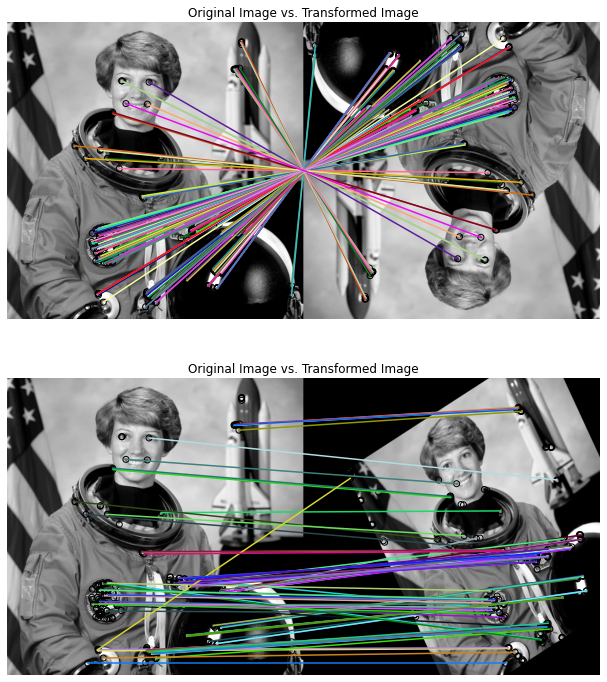

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,12))
plt.gray()
plot_matches(ax[0],image_org, image_rot, keypoints_org, keypoints_rot, matches_org_rot)
ax[0].axis("off")
ax[0].set_title("Original Image vs. Transformed Image")
plot_matches(ax[1], image_org, image_aff, keypoints_org, keypoints_aff, matches_org_aff)
ax[1].axis("off")
ax[1].set_title("Original Image vs. Transformed Image")
plt.show()

### 이미지 이어 붙이기(Image Stitching)
ORB로 이미지에서 특징을 추출하고 다른 이미지에서 동일한 물체를 찾아 대응점을 찾는다

In [63]:
from skimage.feature import ORB, match_descriptors
from skimage.io import imread
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
from skimage.color import rgb2gray
from skimage.io import imsave, show
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity
from skimage.transform import warp
from skimage.transform import SimilarityTransform
import numpy as np

In [54]:
image0 = imread('goldengate1.png')
image0 = rgb2gray(image0)
image1 = imread("goldengate2.png")
image1 = rgb2gray(image1)

<ipython-input-54-3d401c758142>:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image0 = rgb2gray(image0)
<ipython-input-54-3d401c758142>:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image1 = rgb2gray(image1)


In [55]:
orb = ORB(n_keypoints=1000, fast_threshold=0.05)
orb.detect_and_extract(image0)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors
orb.detect_and_extract(image1)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
src = keypoints2[matches12[:,1]][:,::-1]
dst = keypoints1[matches12[:,0]][:,::-1]

In [58]:
transform_model, inliers = ransac((src,dst), ProjectiveTransform, min_samples=4, residual_threshold=2)
r, c = image1.shape[:2]
corners = np.array([[0,0],[0,r],[c,0],[c,r]])
warped_corners = transform_model(corners)
all_corners = np.vstack((warped_corners, corners))
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)

In [59]:
output_shape = (corner_max - corner_min)
output_shape = np.ceil(output_shape[::-1])
offset = SimilarityTransform(translation=-corner_min)

In [65]:
image0_warp = warp(image0, offset.inverse, output_shape = output_shape, cval=-1)
image1_warp = warp(image1, (transform_model + offset).inverse, output_shape=output_shape, cval=-1)
image0_mask = (image0_warp != -1)
image0_warp[~image0_mask] = 0
image0_alpha = np.dstack((gray2rgb(image0_warp), image0_mask))
image1_mask = (image1_warp != -1)
image1_warp[~image1_mask] = 0
image1_alpha = np.dstack((gray2rgb(image1_warp), image1_mask))
merged = (image0_alpha + image1_alpha)
alpha = merged[...,3]
merged /= np.maximum(alpha,1)[...,np.newaxis]
imsave("output.png",merged)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


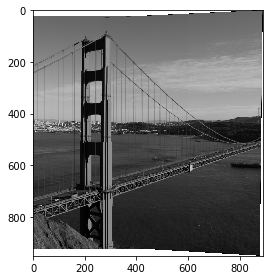

In [69]:
img = io.imread("output.png")
io.imshow(img)
io.show()